## Import modules and Costumize Graphics

In [62]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import os, time, math, datetime
import matplotlib
from scipy import stats
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
sb.set_context("talk", font_scale=1.8)
sb.set_style("whitegrid", {"grid.linewidth": .3,'grid.color': " .95"})
sb.set_style("whitegrid", {"grid.linewidth": .3,'grid.color': " .95"})
matplotlib.rc('font', family='FreeSerif') 
plt.rcParams.update({'figure.max_open_warning': 0})

## Import 'Raw' and 'setting' sheets and preprocess them

In [63]:
# path to file
mypath  = 'C:\\PhD\\Results\\Bio assay\\Bacteria\\15.9.16 e. coli\\15.9.16 E.COLI.xlsx'

# import setting sheet
setting = pd.read_excel(mypath,sheetname='setting', parse_cols='A:Z')
# number of treatments and repetitions
num_of_treats = len(setting.loc['B'])- 2   
num_of_repet = np.diff([ord(char) for char in setting[setting[2]=='Lb'].index])[0]-1 

# Read 'Raw' sheet
rows2skip = range(40) # rows to skip 
rows2skip.extend(range(40+3+(num_of_treats+2)*(num_of_repet+2),300))

raw = pd.read_excel(mypath,sheetname='Raw', skiprows=rows2skip)
raw = raw.transpose()  # transpose dataframe
raw.columns = raw.iloc[0,:].tolist()
raw = raw.ix[1:]
raw.iloc[1:,2:] = raw.iloc[:,2:] - raw.iloc[0,2:]

    Time [s] Temp. [°C]      A1      A2      A3      A4      A5      A6  \
1          0       21.6  0.0983  0.0956   0.097  0.0948  0.0951  0.0956   
2        600       25.2  0.0979  0.0969  0.0981  0.0957   0.096  0.0962   
3       1200       36.7  0.0981  0.0975   0.099  0.0963   0.096  0.0967   
4     1799.9       36.9  0.0985  0.0978  0.0992  0.0962  0.0956  0.0957   
5     2399.9       37.3   0.098  0.0969  0.0983  0.0953  0.0953   0.095   
6     2999.9       37.2  0.0975  0.0955  0.0967  0.0933  0.0935  0.0931   
7     3599.9       37.1  0.0961  0.0942  0.0951   0.092   0.092  0.0916   
8     4199.8       36.9  0.0956  0.0934  0.0943  0.0914  0.0913  0.0909   
9     4799.8       37.1  0.0954  0.0932   0.094  0.0913  0.0909  0.0909   
10    5399.8       37.2  0.0945  0.0934  0.0948  0.0911  0.0911  0.0909   
11    5999.8       37.3  0.0947  0.0931  0.0948   0.091  0.0908  0.0907   
12    6599.7       36.9   0.094   0.093  0.0947  0.0906  0.0906  0.0903   
13    7199.7       37.2  

## Calculate stats

In [64]:
#  create dictionary of number -> treatment name
keys_  = setting.columns[1:-1]
values_ = [str(u) for u in setting.iloc[1,1:-1].values]
treat_dict = dict(zip(keys_, values_))
treat_dict.values()

# letters of repetitions (e.g.:  B, C, D)
reps_letters = [str(s) for s in setting.ix[1:1+num_of_repet].index] 
stats_df = raw.iloc[:,0:2].copy(deep=True)
cols = [str(s) for s in raw.columns[2:]]
cols = [c for c in cols if c[0] in reps_letters] #columns containing our data
for i,j in treat_dict.iteritems():  
    tr_columns = [c  for c in cols if c[1:]==str(i)]     # columns that belong to  treat
    stats_df[j +'_mean'] = raw[tr_columns].mean(axis=1) # mean of each treat
    stats_df[j +'_std'] = raw[tr_columns].std(axis=1) # std
    stats_df[j +'_stderr'] = raw[tr_columns].std(axis=1)/np.sqrt(len(tr_columns)) # stderror
stats_df['Time [h]'] = stats_df['Time [s]']/3600.0

# P_VALUE for each cycle

treats_list = list()  # list columns that belong to  each treat
for i,j in treat_dict.iteritems():  
    treats_list.append([c  for c in cols if c[1:]==str(i)])

#  create empty series for p_value
p = np.empty(len(stats_df))
p[:] = np.nan
stats_df['p_value'] = pd.Series(p, index=stats_df.index)

# calculate p_value for each row
for i,row in raw.iterrows():
    data =[pd.to_numeric(row[cls]).values for cls in treats_list]
    stats_df.loc[i,'p_value'] = stats.f_oneway(*data)[1]
    
# save stats_df in Excel file
stats_df.to_excel(os.path.join(os.path.dirname(mypath),'python_stats_output.xlsx'))

## Plot all Results

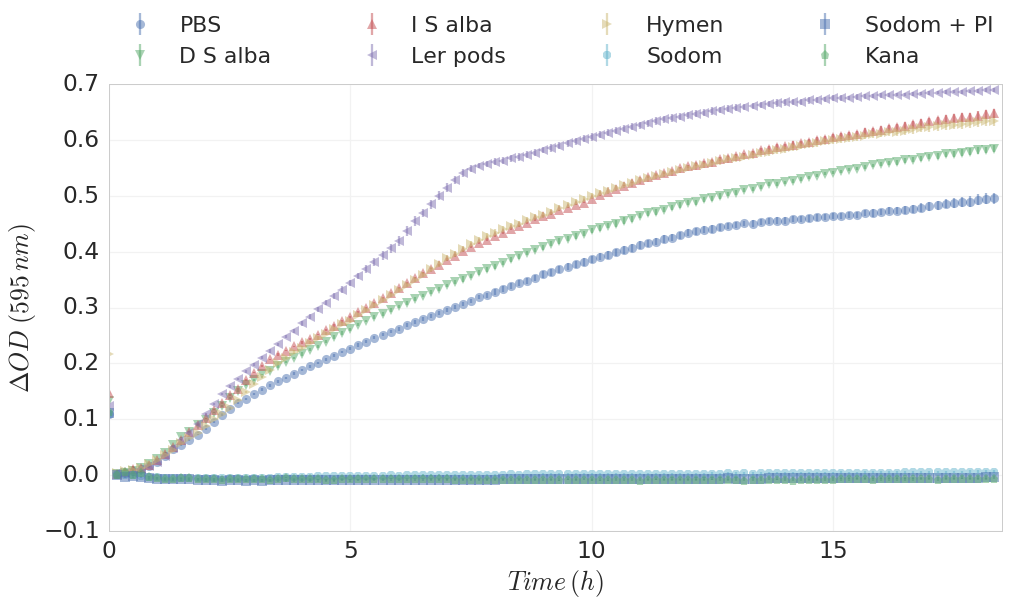

In [65]:
# plot treatments with std error bars

marks =  ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd')

fig, ax = plt.subplots(figsize=(16,8))
x=stats_df['Time [h]'].values
for i,tr in enumerate(treat_dict.itervalues()):
    y=stats_df[tr+'_mean'].values
    ax.errorbar(x,y,yerr=stats_df[tr+'_stderr'].values,fmt=marks[i],alpha=0.5,label=tr);
ax.set_xlim([0,np.max(stats_df['Time [h]'])])
ax.set_ylabel('$\Delta OD \,\, (595\,nm)$')
ax.set_xlabel('$Time \, (h)$')

# plot vertical line where p_value above threshold
thresh = 0.05 # significance level 
boolp = stats_df['p_value'] > thresh # boolean if pvalue< threshold
b, t =ax.get_ylim()
xi = stats_df['Time [h]'][boolp].values
# plot vertical line
# ax.vlines(xi,b,t,'lightgray',alpha=0.7,linewidth=7.5,label='p_value > threshold')
_ = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.,fontsize=22);
fig.savefig(os.path.join(os.path.dirname(mypath),'result1.png'),dpi=300,bbox_inches='tight')

## checkboxes to plot part of the data only

In [66]:
import IPython.html.widgets as widgets
from IPython.display import display, clear_output
bool_treatments = np.zeros(len(values_),dtype=bool).tolist()
rs = []
for i,v in enumerate(bool_treatments):
    rs.append(widgets.Checkbox(False,description=values_[i]))
    display(rs[i])

## filter and plot only selected treatments

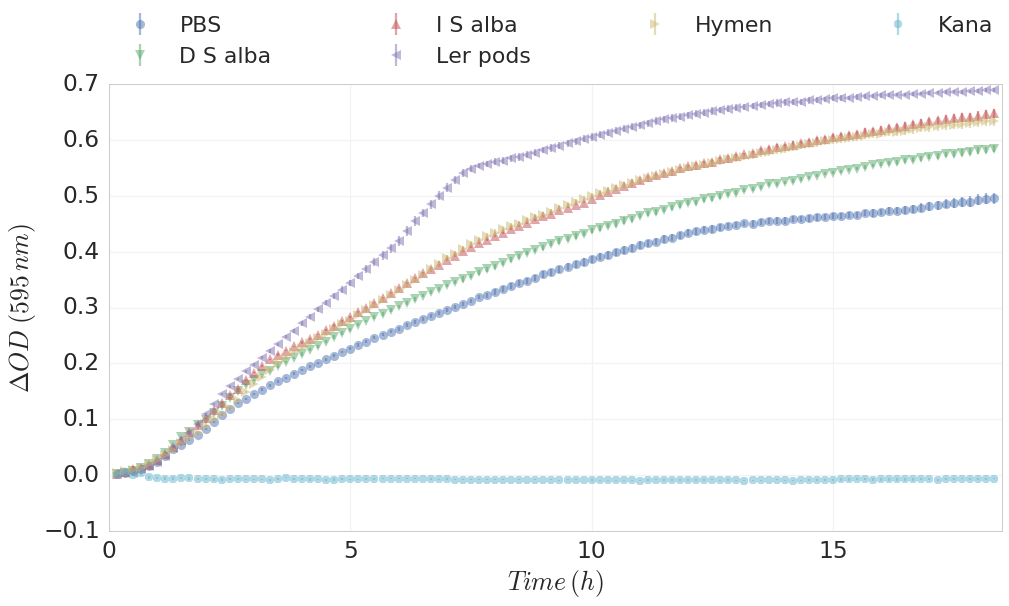

In [72]:
for i,v in enumerate(bool_treatments):
    v = rs[i].value
    bool_treatments[i] = v
    
vals2plot = [val for i,val in enumerate(values_) if bool_treatments[i]==True]
treat2plot_dict = treat_dict.copy()
treat2plot_dict = {key: value for key, value in treat2plot_dict.items() if value  in vals2plot}

fig, ax = plt.subplots(figsize=(16,8))
x=stats_df.iloc[1:]['Time [h]'].values
for i,tr in enumerate(treat2plot_dict.itervalues()):
    
    y=stats_df.iloc[1:][tr+'_mean'].values
    ax.errorbar(x,y,yerr=stats_df.iloc[1:][tr+'_stderr'].values,fmt=marks[i],alpha=0.5,label=tr);
ax.set_xlim([0,np.max(stats_df['Time [h]'])])
ax.set_ylabel('$\Delta OD \,\, (595\,nm)$')
ax.set_xlabel('$Time \, (h)$')

# plot vertical line where p_value above threshold
thresh = 0.05 # significance level 
boolp = stats_df['p_value'] > thresh # boolean if pvalue< threshold
b, t =ax.get_ylim()
xi = stats_df['Time [h]'][boolp].values
# plot vertical line
# ax.vlines(xi,b,t,'lightgray',alpha=0.7,linewidth=7.5,label='p_value > threshold')
_ = ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.,fontsize=22);
fig.savefig(os.path.join(os.path.dirname(mypath),'_'.join(vals2plot)+'_result.png'),dpi=300,bbox_inches='tight')